In [1]:
import spotipy as sp
import spotipy.util as util

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from collections import Counter

import pickle
import numbers
import itertools


In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def getTrainTestY(names):
    """
    Load data from multiple genres and split in in a test, train and validation set and create the label vector
    """
    trainsets = []
    testsets = []
    valsets = []
    ytrain = []
    ytest = []
    yval = []
    for i, name in enumerate(names):
        dataset = pd.read_pickle("datasets/" + name)

        # split up in train test
        trainsets += list(dataset[:int(0.6*len(dataset))].as_matrix())
        testsets += list(dataset[int(0.6 * len(dataset)):int(0.8 * len(dataset))].as_matrix())
        valsets += list(dataset[int(0.8 * len(dataset)):].as_matrix())

        # create y vector
        yvector = list(np.repeat(i, len(dataset)))
        ytrain += yvector[:int(0.6 * len(dataset))]
        ytest += yvector[int(0.6 * len(dataset)):int(0.8 * len(dataset))]
        yval += yvector[int(0.8 * len(dataset)):]
        
    
    np_scaled = preprocessing.scale(np.vstack((np.vstack((trainsets, testsets)), valsets)))
    trainsets = pd.DataFrame(np_scaled[:len(ytrain)])
    #np_scaled = preprocessing.scale(testsets)
    testsets = pd.DataFrame(np_scaled[len(ytrain):len(ytrain) + len(ytest)])
    valsets = pd.DataFrame(np_scaled[len(ytrain) + len(ytest):])
    
    
    
    return trainsets, testsets,valsets, ytrain, ytest, yval
names = ["classical_features", "hiphop_features", "rock_features", "house_features", "hardcore_features", "jazz_features", "k-pop_features", "grunge_features"]
train, test, validate, y_train, y_test, y_val = getTrainTestY(names)

In [41]:
# Fit a KNN classifier
clf = neighbors.KNeighborsClassifier(9, weights='distance')
clf.fit(train, y_train)
test_results = clf.predict(test)

In [42]:
# Check the performance of the classifier compared to the true label
def evaluate(labels, true_labels):
    good = 0
    wrong = 0
    for result, true_label in zip(labels, true_labels):
        if result == true_label:
            good += 1
        else:
            wrong += 1
    return good, wrong
result = evaluate(test_results, y_test)
result[0] / (result[1] + result[0])

0.6483125

Confusion matrix, without normalization


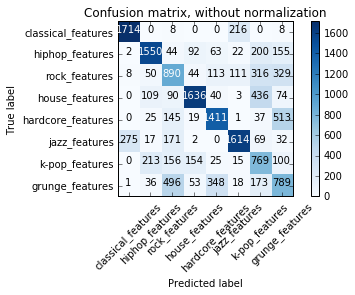

In [43]:
# Plot a confusion matrix to see if some classes are often confused with eachother
cnf_matrix = confusion_matrix(test_results, y_test)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=names,
                      title='Confusion matrix, without normalization')
plt.show()

# Bootstrapping for confidence intervals

In [7]:
from scipy import spatial
# spatial.distance.cosine([1,0], [1,1])

def bootstrap(sample, amount):
    # Create indexes of the numbers we want (this numpy call could be)
    # replaced with our random generator from last week, it does the same.
    indexes = np.random.randint(0, len(sample), amount)
    new_sample = []
    # Get all items and store them
    for index in indexes:
        new_sample += [sample[index]]
    return  new_sample

#[True if x == 0 else False for x in y_test]
locations = np.array(y_val) == 0
space = np.array(validate)
subspace = [i for indx,i in enumerate(space) if locations[indx] == True]

In [8]:
total_sample_size = 100
new_sample = bootstrap(subspace, int(0.9 * total_sample_size)) + bootstrap(space, int(0.1 * total_sample_size))


In [76]:
sample_predictions = clf.predict(new_sample)
sample_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 3,
       4, 1, 0, 4, 6, 3, 3, 7])

In [77]:
# Add a 0 for classes that weren't used in the classification so this vector gets the same size
# as a row from the confusion matrix.
sample_predictions_dict = Counter(sample_predictions)
for i in range(len(names)):
    if i not in sample_predictions_dict.keys():
        sample_predictions_dict[i] = 0
print(sample_predictions_dict)
print(sample_predictions_dict.values())
print(cnf_matrix[0])

Counter({0: 85, 5: 5, 3: 3, 4: 2, 6: 2, 1: 1, 2: 1, 7: 1})
dict_values([85, 1, 1, 3, 2, 5, 2, 1])
[1714    0    8    0    0  216    0    8]


In [11]:
# 
1 - spatial.distance.cosine(list(other_vector_dict.values()), cnf_matrix[2])

0.040381457751404781

In [54]:
# Create a playlist of 90% one class and 10% random songs, classify the songs and compute the cosine similarity
def bootstrap_class(class_number, cnf_matrix, valset, y_val, total_sample_size = 100, amount = 1000):
    # Get a dataframe with only the songs from the class
    locations = np.array(y_val) == class_number
    space = np.array(valset)
    subspace = [i for indx,i in enumerate(space) if locations[indx] == True]
    scores = []
    # Get playlists, predict them and save the cosine similarity
    for i in range(amount):
        new_sample = bootstrap(subspace, int(0.9 * total_sample_size)) + bootstrap(space, int(0.1 * total_sample_size))
        classifications = Counter(clf.predict(new_sample))
        for i in range(len(names)):
            if i not in list(classifications.keys()):
                classifications[i] = 0
        scores += [1 - spatial.distance.cosine(list(classifications.values()), cnf_matrix[class_number])]

    return scores

# For every class create 1000 playlists of 100 songs to classify
cosines = []
for i in range(len(names)):
    cosines +=  [bootstrap_class(i, cnf_matrix, validate, y_val)]

In [55]:
# Calculate the confidence intervals on the cosine similarities
confidence_intervals = []
for genre_samples in cosines:
    confidence_intervals += [np.percentile(genre_samples, 0.05)]
confidence_intervals

[0.97663383082237043,
 0.97611116387054087,
 0.81852088173746673,
 0.96456202765781618,
 0.96271397063158748,
 0.98463624288791607,
 0.87364601354287097,
 0.88292620026237634]

In [17]:
# Spotipy to get features of the songs in the manually collected playlists
import spotipy as sp
import numbers
import spotipy.util as util

SPOTIPY_REDIRECT_URI='http://localhost:8888/callback'
SPOTIPY_CLIENT_SECRET='c02f97ddd119470d8e24b290722c7490'
SPOTIPY_CLIENT_ID='647ffb8c163b4882be0cafe4bf1352d5'
USERNAME='lh7smhcywr18vctg4xmnoehzu'
SCOPE='user-library-read'

token = util.prompt_for_user_token(username=USERNAME,
                           scope=SCOPE,
                           client_id=SPOTIPY_CLIENT_ID,
                           client_secret=SPOTIPY_CLIENT_SECRET,
                           redirect_uri=SPOTIPY_REDIRECT_URI)

s = sp.Spotify(auth=token)

In [23]:
p1 = s.user_playlist_tracks("xnikeboyx", "5zuAnrEQmLlri78gHVzJEx")

def get_audio_features(ids):
    """Collect all audio features in a list from a given list of track id's"""
    audio_feats = []

    for i in range(0, len(ids), 100):
        audio_feats += s.audio_features(ids[i:i + 100])

    return audio_feats
def getDataframe(features):
    matrix = []
    metamatrix = []

    columns = list(features[0].keys())
    matrix_columns = columns[:11] + columns[-2:]
    metamatrix_columns = columns[11:-2]

    for track in features:        
        vals = list(track.values())
        try:
            matrix += [vals[:11] + vals[-2:]]
            metamatrix += [vals[11:-2]]
        except:
            pass
        
    return (pd.DataFrame(matrix, columns=matrix_columns),
            pd.DataFrame(metamatrix, columns=metamatrix_columns))



def get_random_sample(genre, iters = 20):
    """Main function"""
    query = s.search(q='genre:{0}'.format(genre))
    tracks = []
    
    i = 0
    
    while query['tracks']['next']:
        print(i)
        tracks.extend(query['tracks']['items'])
        query = s.next(query['tracks'])
        
        i += 1
        
        if i == iters:
            break
            
    feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
  
    # These steps are not computationally expensive
    track_ids = get_track_ids(tracks, ide=False)
    audio_feats = get_audio_features(track_ids)
    
    return getDataframe(audio_feats)

tracks = []
for item in p1["items"]:
    tracks += [item["track"]["id"]]
    
feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
  'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

# These steps are not computationally expensive
audio_feats = get_audio_features(tracks)
print(audio_feats[0].keys())
matrix_of_features, metamatrix = getDataframe(audio_feats)
df = pd.DataFrame(matrix_of_features)
#df.columns = feature_names


dict_keys(['analysis_url', 'key', 'tempo', 'speechiness', 'id', 'mode', 'track_href', 'liveness', 'instrumentalness', 'time_signature', 'type', 'loudness', 'uri', 'danceability', 'valence', 'energy', 'acousticness', 'duration_ms'])


In [31]:
# For every collected playlist: Get song features and save them
matrices_dict = {}
with open("userID_playlistID.txt", "r") as f:
    all_lines = f.readlines()
    for line in all_lines[:2]:
        userid, playlistid = line.split()
        tracks = []
        for item in p1["items"]:
            tracks += [item["track"]["id"]]
            audio_feats = get_audio_features(tracks)
            matrix_of_features, metamatrix = getDataframe(audio_feats)
            matrices_dict[playlistid] = (matrix_of_features, metamatrix)
        

retrying ...3secs
retrying ...1secs


In [53]:
# Load the collected data from above and classify the songs
matrices_dict = pickle.load(open("datasets/matrices_dict", "rb"))
df = 0
predictions = []
for key in matrices_dict.keys():
    predictions += [Counter(clf.predict(preprocessing.scale(matrices_dict[key][0])))]



In [59]:
# Add 0's to get evenly long vectors
for j in range(len(predictions)):
    for i in range(len(names)):
        if i not in predictions[j].keys():
            predictions[j][i] = 0


In [68]:
# Check how many playlists got a cosine similarity larger than the CI
one_class = 0
for prediction in predictions:
    for row, ci_limit in zip(cnf_matrix, confidence_intervals):
        if (spatial.distance.cosine(list(prediction.values()), row) > ci_limit):
            one_class += 1
one_class


0

## Neural nets

In [69]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras.optimizers import SGD, adam


Using TensorFlow backend.


In [70]:
YNNTrain = np_utils.to_categorical(y_train, 10)
YNNTest = np_utils.to_categorical(y_test, 10)

In [71]:
YNNTest


array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [72]:
model = Sequential()
model.add(Dense(13, activation='relu',  input_dim = 13))
model.add(Dropout(0.02))

model.add(Dense(35, activation='relu'))
model.add(Dropout(0.02))

model.add(Dense(15, activation='relu'))
model.add(Dropout(0.02))

model.add(Dense(15, activation='relu'))
model.add(Dropout(0.02))

model.add(Dense(len(YNNTest[0]), activation='softmax'))

In [73]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [74]:
# Compile model
epochs = 10
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimi = adam()
model.compile(loss='categorical_crossentropy', optimizer=optimi, metrics=['accuracy'])


In [75]:
model.fit(train.as_matrix(), YNNTrain, batch_size = 24, epochs = epochs, verbose = 1)


Epoch 1/10
48000/48000 [==============================] - 3s - loss: 1.0976 - acc: 0.5687     
Epoch 2/10
48000/48000 [==============================] - 2s - loss: 0.8692 - acc: 0.6621     
Epoch 3/10
48000/48000 [==============================] - 2s - loss: 0.8389 - acc: 0.6751     
Epoch 4/10
48000/48000 [==============================] - 2s - loss: 0.8226 - acc: 0.6816     
Epoch 5/10
48000/48000 [==============================] - 2s - loss: 0.8103 - acc: 0.6879     
Epoch 6/10
48000/48000 [==============================] - 2s - loss: 0.8008 - acc: 0.6901     
Epoch 7/10
48000/48000 [==============================] - 2s - loss: 0.7975 - acc: 0.6913     
Epoch 8/10
48000/48000 [==============================] - 2s - loss: 0.7890 - acc: 0.6938     
Epoch 9/10
48000/48000 [==============================] - 2s - loss: 0.7839 - acc: 0.6965     
Epoch 10/10
48000/48000 [==============================] - 2s - loss: 0.7805 - acc: 0.6964     
